In [14]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing



%matplotlib inline

In [15]:
with open("initial_df.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

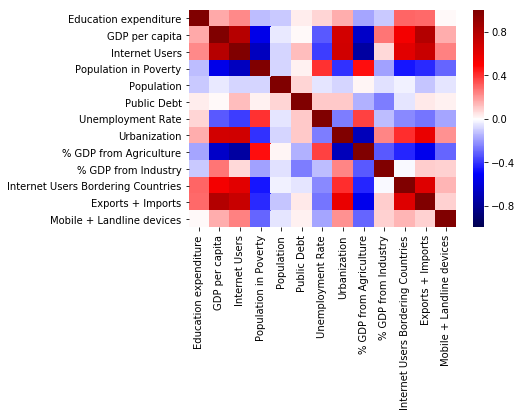

In [16]:
# Split into training and test data and plot correlation heatmap

df_train,df_test = train_test_split(df, test_size=0.4, random_state=1)
df_corr = df_train.corr()

column_mapper = {"education_exp": "Education expenditure", \
                 "gdp_per_capita": "GDP per capita", \
                 "internet_users": "Internet Users", \
                 "pop_below_pov":"Population in Poverty", \
                 "population": "Population", \
                 "public_debt": "Public Debt", \
                 "unemp_rate":"Unemployment Rate", \
                 "urbanization": "Urbanization", \
                 "agr":"% GDP from Agriculture", \
                 "ind":"% GDP from Industry", \
                 "border_internet_scaled":"Internet Users Bordering Countries", \
                 "total_trade":"Exports + Imports", 'total_tel':"Mobile + Landline devices"}

df_corr = df_corr.rename(columns=column_mapper,index = column_mapper)

sns.heatmap(df_corr, cmap = 'seismic',vmin = -1.0, vmax = 1.0)

# Save the image

plt.savefig('first_heatmap.pdf', bbox_inches="tight")

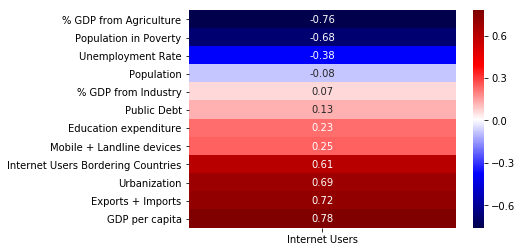

In [17]:
# Zoom in only to the columns of interest

df_corr_internet = pd.DataFrame(df_corr['Internet Users'])
df_corr_internet = df_corr_internet.sort_values(by='Internet Users')
df_corr_internet = df_corr_internet.drop(index="Internet Users")
df_corr_internet = df_corr_internet.round(2)

sns.heatmap(df_corr_internet, annot=True, fmt="g", cmap='seismic',linewidths=.0)

plt.savefig('internet_heatmap.pdf', bbox_inches="tight")


In [18]:

# Pre-processing, standardising between 0 and 1

x = df_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df2 = pd.DataFrame(x_scaled)

df2.columns = df_train.columns
df2.index = df_train.index

df2.head()


,education_exp,gdp_per_capita,internet_users,pop_below_pov,population,public_debt,unemp_rate,urbanization,agr,ind,border_internet_scaled,total_trade,total_tel
Country,,,,,,,,,,,,,
Bangladesh,0.122807,0.024331,0.145486,0.294545,0.123080,0.137056,0.048240,0.239659,0.343980,0.431095,0.307238,0.005615,0.394182
Algeria,0.280702,0.113544,0.406479,0.278788,0.031919,0.109137,0.148631,0.677616,0.319410,0.553004,0.525171,0.032938,0.551941
Vietnam,0.403509,0.046229,0.508925,0.096970,0.074974,0.246193,0.024772,0.231144,0.371007,0.503534,0.553808,0.075555,0.552548
Saint Kitts and Nevis,0.149123,0.207624,0.749920,0.242424,0.000000,0.263959,0.054759,0.169100,0.022113,0.445230,0.571318,0.105899,0.762134
Peru,0.236842,0.098135,0.436989,0.275152,0.024171,0.107868,0.083442,0.742092,0.179361,0.556537,0.616085,0.043438,0.577293


In [20]:
# Initial OLS

y, X = patsy.dmatrices('internet_users ~ agr + urbanization + gdp_per_capita + pop_below_pov + total_trade + total_tel + public_debt + unemp_rate + education_exp + population + border_internet_scaled + ind', data=df2, return_type="dataframe")

model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

# Many p-values higher than expected.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         internet_users   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     34.65
Date:                Fri, 12 Oct 2018   Prob (F-statistic):           1.03e-25
Time:                        13:31:59   Log-Likelihood:                 66.250
No. Observations:                  88   AIC:                            -106.5
Df Residuals:                      75   BIC:                            -74.29
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.6965      0.107      6.539      0.000       0.484       0.909
agr                       -0.4256      0.090     -4.718      0.000      -0.605      -0.246
urbanization               0.1143      0.074      1.546      0.126      -0.033       0.262
gdp_per_capita             0.3850      0.154      2.496      0.015       0.078       0.692
pop_below_pov             -0.4115      0.085     -4.866      0.000      -0.580      -0.243
total_trade                0.1389      0.111      1.246      0.217      -0.083       0.361
total_tel                 -0.0209      0.057     -0.368      0.714      -0.134       0.092
public_debt                0.0656      0.104      0.633      0.528      -0.141       0.272
unemp_rate                -0.0306      0.105     -0.293      0.771      -0.239       0.178
education_exp             -0.0193      0.094     -0.205      0.838      -0.206       0.168
population                -0.2051      0.122     -1.685      0.096      -0.448       0.037
border_internet_scaled     0.1034      0.074      1.396      0.167      -0.044       0.251
ind                       -0.2976      0.085     -3.517      0.001      -0.466      -0.129
==============================================================================
Omnibus:                        0.363   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.834   Jarque-Bera (JB):                0.523
Skew:                           0.115   Prob(JB):                        0.770
Kurtosis:                       2.700   Cond. No.                         21.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# Filter out the ones with low correlation and low p value

df2_corr = df2.corr()
internet_corr = df2_corr.internet_users
filtered_cols = abs(internet_corr)>0.5
internet_corr = internet_corr[list(filtered_cols)]
internet_corr


gdp_per_capita            0.782808
internet_users            1.000000
pop_below_pov            -0.677967
urbanization              0.686781
agr                      -0.758571
border_internet_scaled    0.610743
total_trade               0.715283
Name: internet_users, dtype: float64

                        gdp_per_capita  internet_users  pop_below_pov  \
gdp_per_capita                1.000000        0.782808      -0.557129   
internet_users                0.782808        1.000000      -0.677967   
pop_below_pov                -0.557129       -0.677967       1.000000   
urbanization                  0.674780        0.686781      -0.400280   
agr                          -0.651274       -0.758571       0.475623   
border_internet_scaled        0.543284        0.610743      -0.459857   
total_trade                   0.794252        0.715283      -0.416295   

                        urbanization       agr  border_internet_scaled  \
gdp_per_capita              0.674780 -0.651274                0.543284   
internet_users              0.686781 -0.758571                0.610743   
pop_below_pov              -0.400280  0.475623               -0.459857   
urbanization                1.000000 -0.694100                0.410043   
agr                        -0.694100  1.00000

,gdp_per_capita,pop_below_pov,urbanization,agr,border_internet_scaled,total_trade
gdp_per_capita,1.000000,-0.557129,0.674780,-0.651274,0.543284,0.794252
pop_below_pov,-0.557129,1.000000,-0.400280,0.475623,-0.459857,-0.416295
urbanization,0.674780,-0.400280,1.000000,-0.694100,0.410043,0.581367
agr,-0.651274,0.475623,-0.694100,1.000000,-0.427381,-0.551779
border_internet_scaled,0.543284,-0.459857,0.410043,-0.427381,1.000000,0.628832
total_trade,0.794252,-0.416295,0.581367,-0.551779,0.628832,1.000000


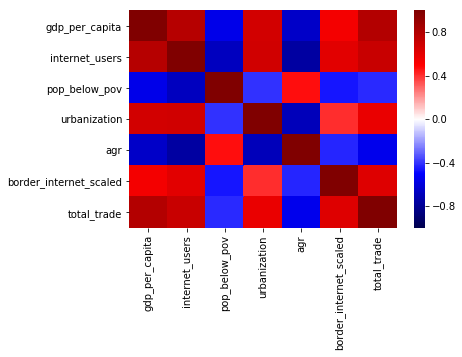

In [22]:
# Basically, each eigen vector explains the variation in the 
# data orthogonal to other eigen vectors, 
# and the eigen value shows how much variation is in that direction. 
# An almost zero eigen value shows a direction with zero variation, hence collinearity

df3 = df2.drop(columns = ['ind', 'total_tel', 'public_debt', 'education_exp', 'population', 'unemp_rate'])
df3_corr = df3.corr()
print(df3_corr)

sns.heatmap(df3.corr(), cmap = "seismic",vmin = -1.0, vmax = 1.0)

df3_corr = df3_corr.drop(columns = 'internet_users')
df3_corr = df3_corr.drop('internet_users')

df3_corr

In [24]:

# We see that gdp_per_capita, pop_below_pov, urbanization are all colinear. Here, small values are index 1, index 5.
# I defined small by being below 0.5. Tried PCA but makes the axis uninterperitable.


w, v = np.linalg.eig(df3_corr)
w

array([3.78366701, 0.16290592, 0.7222333 , 0.63336049, 0.40423587,
       0.29359742])

In [25]:
df3_corr

,gdp_per_capita,pop_below_pov,urbanization,agr,border_internet_scaled,total_trade
gdp_per_capita,1.000000,-0.557129,0.674780,-0.651274,0.543284,0.794252
pop_below_pov,-0.557129,1.000000,-0.400280,0.475623,-0.459857,-0.416295
urbanization,0.674780,-0.400280,1.000000,-0.694100,0.410043,0.581367
agr,-0.651274,0.475623,-0.694100,1.000000,-0.427381,-0.551779
border_internet_scaled,0.543284,-0.459857,0.410043,-0.427381,1.000000,0.628832
total_trade,0.794252,-0.416295,0.581367,-0.551779,0.628832,1.000000


In [30]:
# Exploring index 5 we find that agr and urbanization are colinear, so we must remove one. 
# Also, gdp_per_capita and total_trade are colinear (index 1)
v[:,5]

array([ 0.05980139,  0.11728544, -0.71571257, -0.65783293, -0.10019009,
        0.16625645])

In [32]:

# Chose to filter our urbanisation and total_trade

y, X = patsy.dmatrices('internet_users ~ agr + gdp_per_capita + pop_below_pov + border_internet_scaled', data=df2, return_type="dataframe")


model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

# In our results we see that agr and urbanization which are both high correlation have high p value. 
# First lets drop the columns that have low correlation and low p-value


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         internet_users   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     80.52
Date:                Fri, 12 Oct 2018   Prob (F-statistic):           9.11e-28
Time:                        13:35:05   Log-Likelihood:                 53.344
No. Observations:                  88   AIC:                            -96.69
Df Residuals:                      83   BIC:                            -84.30
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.5549      0.061      9.155      0.000       0.434       0.675
agr                       -0.4349      0.080     -5.405      0.000      -0.595      -0.275
gdp_per_capita             0.5275      0.124      4.257      0.000       0.281       0.774
pop_below_pov             -0.3514      0.086     -4.071      0.000      -0.523      -0.180
border_internet_scaled     0.1993      0.072      2.774      0.007       0.056       0.342
==============================================================================
Omnibus:                        3.697   Durbin-Watson:                   2.183
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                2.988
Skew:                          -0.416   Prob(JB):                        0.225
Kurtosis:                       3.349   Cond. No.                         11.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1305]:
# So final feature list is gdp_per_capita, pop_under_pov, agr, border_internet_scaled